# <a id='toc1_'></a>[OpenVINO™ Explainable AI Toolkit: Classification Explanation](#toc0_)

**OpenVINO™ Explainable AI (XAI) Toolkit** provides a suite of XAI algorithms for visual explanation of
[OpenVINO™](https://github.com/openvinotoolkit/openvino) Intermediate Representation (IR) models.

This notebook shows an example how to use OpenVINO XAI.

It depicts a heatmap with areas of interest where neural network (classification or detection) focuses before making a decision. 

Model explanation helps to identify the parts of the input that are responsible for the model's prediction, which is useful for analyzing model's performance.

**Table of contents**<a id='toc0_'></a>    
- [OpenVINO™ Explainable AI Toolkit: Classification Explanation](#toc1_)    
- [Prerequisites](#toc2_)    
  - [Install requirements](#toc2_1_)    
  - [Imports](#toc2_2_)    
  - [Get IR model](#toc2_3_)    
  - [Get image](#toc2_4_)    
- [Basic usage: Auto mode explainer](#toc3_)    
  - [Save saliency maps](#toc3_1_)    
  - [Return saliency maps for all classes](#toc3_2_)    
  - [Visualization Parameters](#toc3_3_)    
- [White Box explainer](#toc4_)    
  - [Recipro-CAM explain method](#toc4_1_)    
  - [Activation map explain method](#toc4_2_)    
  - [Insertion-related parameters](#toc4_3_)    
  - [Insert XAI branch](#toc4_4_)    
- [Black Box explainer](#toc5_)    
- [Advanced](#toc6_)    
  - [Import ImageNet label names and add them to saliency maps](#toc6_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Prerequisites](#toc0_)
## <a id='toc2_1_'></a>[Install requirements](#toc0_)


In [1]:
# Make sure to use python3.10 and higher
# %pip install openvino-xai==1.0.0rc0
# %pip install pip install matplotlib

# Some changes to openvino_xai were applied, install in editable mode in this PR
! pip install -e ../..

Obtaining file:///home/gzalessk/code/openvino_xai
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for openvino_xai (pyproject.toml) ... done
  Created wheel for openvino_xai: filename=openvino_xai-1.1.0rc1-0.editable-py3-none-any.whl size=12841 sha256=7142bcad1f1ebcfae0ee4c019eb478a73c90db07f0ea046ea5ca9210c386cec8
  Stored in directory: /tmp/pip-ephem-wheel-cache-08j7716u/wheels/06/69/07/d49bdb07e9251104d2d92dd872e5df2c6628182ee83810e6dc
Successfully built openvino_xai
  Attempting uninstall: openvino_xai
    Found existing installation: openvino_xai 1.1.0rc1
    Uninstalling openvino_xai-1.1.0rc1:
      Successfully uninstalled openvino_xai-1.1.0rc1


## <a id='toc2_2_'></a>[Imports](#toc0_)

In [2]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino.runtime as ov

import openvino_xai as xai
from openvino_xai.common.parameters import Task, Method
from openvino_xai.common.utils import retrieve_otx_model
from openvino_xai.explainer.mode import ExplainMode, TargetExplainGroup

from openvino_xai.explainer.explanation import Explanation

## <a id='toc2_3_'></a>[Get IR model](#toc0_)

In this notebook for demonstration purposes we'll use an already converted to IR model from OpenVINO storage. That model originally from timm storage and requires timm preprocessing (proper scaling and normalization).

You are able to run explainer on any IR model as far as passed `preprocess_fn` reflect preprocessing required for the actual model.

In [3]:
# Download test IR (.bin+.xml) model from our repository or use your own
retrieve_otx_model(
    ".",  # Destination folder
    "mobilenetv3_large_100.ra_in1k",  # Model name
    dir_url="https://storage.openvinotoolkit.org/repositories/openvino_training_extensions/models/custom_image_classification",
)

# Please manually check the size of the downloaded model to be more than 2 KB
model_path = "./otx_models/mobilenetv3_large_100.ra_in1k.xml"

## <a id='toc2_4_'></a>[Get image](#toc0_)

Where to put image? Request call?

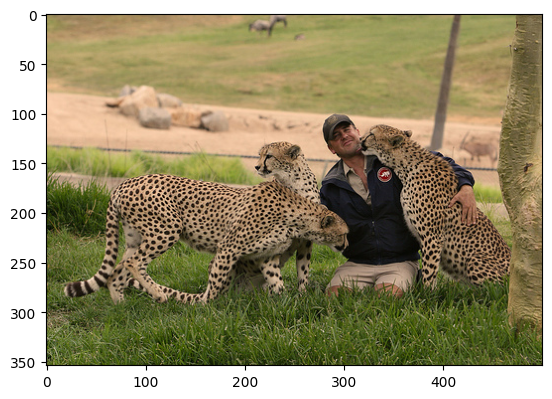

In [4]:
output_path = Path("./saliency_maps")

# Get the image
image_path = "../../tests/assets/cheetah_person.jpg"
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
image_name = Path(image_path).stem

plt.imshow(image)
plt.show()

# <a id='toc3_'></a>[Basic usage: Auto mode explainer](#toc0_)

Under the hood of the auto mode: will try to run white-box mode, if fails => will run black-box mode. See more details about white_box and black-box modes below.

Generating saliency maps involves model inference. Explainer will perform model inference.

White-box mode requires only `preprocess_fn`, black-box - both `preprocess_fn` and `postprocess_fn`. Since it's unclear which mode will be used, it's required to pass both these functions.

In [5]:
from openvino_xai.common.utils import preprocess_fn, postprocess_fn

# Create ov.Model
model = ov.Core().read_model(model_path)

# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    # Pre-process and post-process function should be implemented based on model's implementation, 
    # Using standart preprocessing and postprocessing function here
    preprocess_fn=preprocess_fn,
    postprocess_fn=postprocess_fn,
)

# Generate explanation, by default you can chose classes to generate maps for.
cheetah_class_index = 293
explanation = explainer(image, target_explain_labels=[cheetah_class_index])

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).


INFO:openvino_xai:Explaining the model in white-box mode.


Saliency maps were generated for the following classes: [293]
Saliency map size: (354, 500, 3)


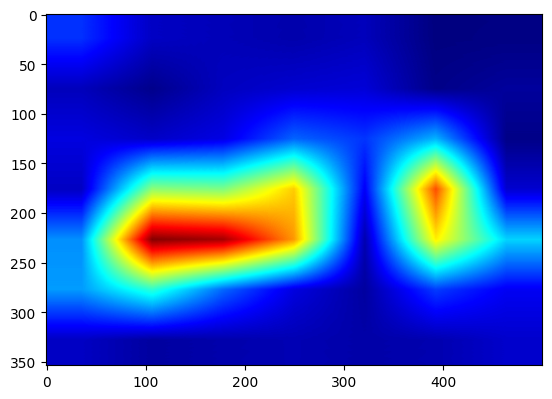

In [6]:
explanation: Explanation
explanation.saliency_map  # Dict[int: np.ndarray] where key - class id, value - processed saliency map e.g. 354x500x3

# Check saved saliency maps
print(f"Saliency maps were generated for the following classes: {list(explanation.saliency_map.keys())}")
print(f"Saliency map size: {explanation.shape}")

# Show saliency maps for cheetah class
cheetah_raw_sal_map = explanation.saliency_map[cheetah_class_index]
cheetah_raw_sal_map = cv2.cvtColor(cheetah_raw_sal_map, cv2.COLOR_BGR2RGB)

plt.imshow(cheetah_raw_sal_map)
plt.show()

## <a id='toc3_1_'></a>[Save saliency maps](#toc0_)

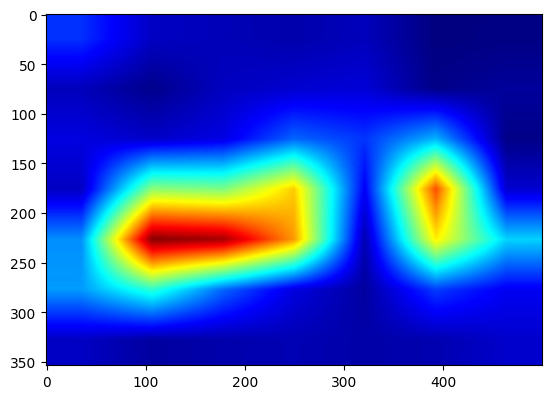

In [7]:
# Save saliency map
output = output_path / "explain_auto"
explanation.save(output, image_name)

# See saved saliency maps
image_sal_map = cv2.imread(f"{output}/{image_name}_target_{cheetah_class_index}.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map)
plt.show()

## <a id='toc3_2_'></a>[Return saliency maps for all classes](#toc0_)

In [8]:
explanation = explainer(image, target_explain_group=TargetExplainGroup.ALL)

# Check saved saliency maps
print(f"Saliency maps were generated for the following classes: {list(explanation.saliency_map.keys())}")
print(f"Saliency map size: {explanation.shape}")

error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:3789: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


## <a id='toc3_3_'></a>[Visualization Parameters](#toc0_)

- resize (True): If True, resize saliency map to the input image size.
- colormap (True): If True, apply colormap to the grayscale saliency map.
- overlay (False): If True, generate overlay of the saliency map over the input image.
- overlay_weight (0.5): Weight of the saliency map when overlaying the input data with the saliency map.

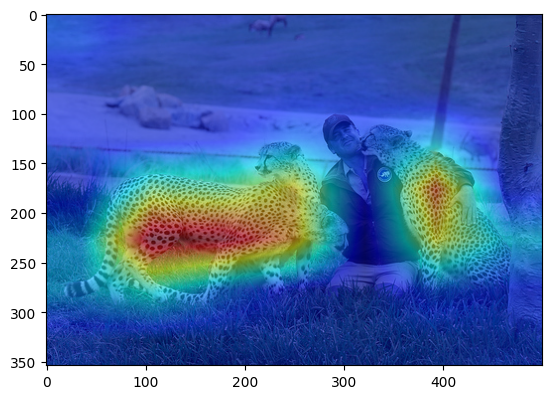

In [9]:
# Return overlayed image
explanation = explainer(image, 
                        target_explain_group=TargetExplainGroup.CUSTOM,
                        target_explain_labels=[293],
                        overlay=True,
                        )

cheetah_raw_sal_map = explanation.saliency_map[cheetah_class_index]
cheetah_raw_sal_map = cv2.cvtColor(cheetah_raw_sal_map, cv2.COLOR_BGR2RGB)

plt.imshow(cheetah_raw_sal_map)
plt.show()

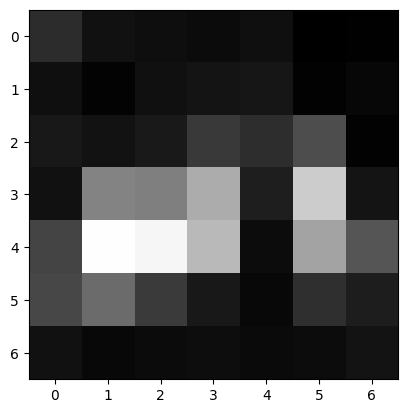

In [10]:
# Return low-resolution gray-scale saliency map
explanation = explainer(image, 
                        target_explain_group=TargetExplainGroup.CUSTOM,
                        target_explain_labels=[293],
                        resize=False,
                        colormap=False,
                        )

cheetah_raw_sal_map = explanation.saliency_map[cheetah_class_index]
cheetah_raw_sal_map = cv2.cvtColor(cheetah_raw_sal_map, cv2.COLOR_BGR2RGB)

plt.imshow(cheetah_raw_sal_map)
plt.show()

# <a id='toc4_'></a>[White Box explainer](#toc0_)
## <a id='toc4_1_'></a>[Recipro-CAM explain method](#toc0_)
The White-Box explainer treats model as a white box and needs to make inner modifications. It adds extra XAI nodes after backbone to estimate which activations are important for model prediction.

If method wasn't specifed, XAI branch will be generated with [ReciproCAM](https://arxiv.org/abs/2209.14074) method.

By default, the insertion of XAI branch will be done automatically by searching correct node.

It works fast and precise and requires only one model inference.

In [12]:
# Create ov.Model
model = ov.Core().read_model(model_path)

# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    
    # defaults to ExplainMode.AUTO
    explain_mode=ExplainMode.WHITEBOX,
    # ReciproCAM is the default XAI method for CNNs
    explain_method=xai.Method.RECIPROCAM,
)

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).


INFO:openvino_xai:Explaining the model in white-box mode.


## <a id='toc4_2_'></a>[Activation map explain method](#toc0_)

In case of explanation `explain_method==Method.ACTIVATIONMAP`, instead of saliency map for each class the activation map is returned as `explanation.saliency_map["per_image_map"]`.

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ActivationMap method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


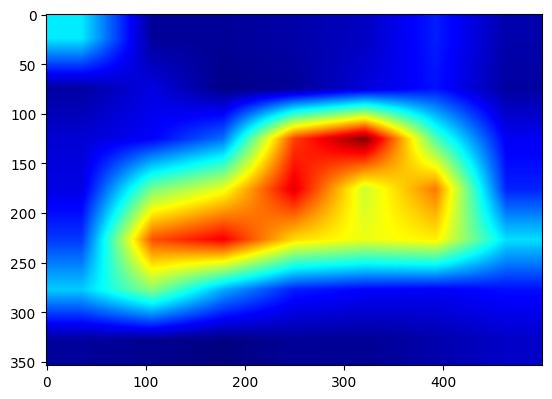

In [13]:
# Create ov.Model
model = ov.Core().read_model(model_path)

# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.WHITEBOX,
    
    explain_method=xai.Method.ACTIVATIONMAP,
)

explanation = explainer(image, target_explain_group=TargetExplainGroup.IMAGE)
activation_map = explanation.saliency_map["per_image_map"]
activation_map = cv2.cvtColor(activation_map, cv2.COLOR_BGR2RGB)

plt.imshow(activation_map)
plt.show()

## <a id='toc4_3_'></a>[Insertion-related parameters](#toc0_)

If automatic search for correct node fails, you can set up a correct node manually with `target_layer` argument. 
For classification it's the last backbone node with shape [-1, num_channels, feature_map_height, feature_map_width]. For example, for MobileNetV3 it will be `/backbone/conv/conv.2/Div` layer with [-1, 960, 7, 7] input shape.

`embed_scaling` **default True** (for speed purposes), this parameter adds normalization to the XAI branch, which results in being able to visualize saliency maps right away without further postprocessing.

In [14]:
# Create ov.Model
model = ov.Core().read_model(model_path)

# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.WHITEBOX,
    explain_method=xai.Method.RECIPROCAM,
    
    # target_layer="last_conv_node_name",  # target_layer - node after which XAI branch will be inserted
    target_layer="/blocks/blocks.6/blocks.6.0/bn1/act/HardSwish",  # OTX mnet_v3
    # target_layer="/backbone/features/final_block/activate/Mul",  # OTX effnet
    embed_scaling=True, # True by default.  If set to True, saliency map scale (0 ~ 255) operation is embedded in the model
)

INFO:openvino_xai:Target insertion layer /blocks/blocks.6/blocks.6.0/bn1/act/HardSwish is provided.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).


INFO:openvino_xai:Explaining the model in white-box mode.


## <a id='toc4_4_'></a>[Insert XAI branch](#toc0_)

It's possible to update model with XAI branch to save it and use it in own pipeline.
This code will return IR model with an additional `saliency_map` output.
    

In [15]:
# Create original ov.Model
model = ov.Core().read_model(model_path)

# insert XAI branch
model_xai: ov.Model
model_xai = xai.insert_xai(
    model,
    task=xai.Task.CLASSIFICATION,
    explain_method=xai.Method.RECIPROCAM,
    target_layer="/blocks/blocks.6/blocks.6.0/bn1/act/HardSwish",  # OTX mnet_v3
    embed_scaling=True,
)

INFO:openvino_xai:Target insertion layer /blocks/blocks.6/blocks.6.0/bn1/act/HardSwish is provided.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).


INFO:openvino_xai:Insertion of the XAI branch into the model was successful.


# <a id='toc5_'></a>[Black Box explainer](#toc0_)

The Black Box treats the model as a black box without altering its structure. So, this method will work on any model that can be inferred and return the class probabilities as output.

The [RISE](https://arxiv.org/pdf/1806.07421.pdf) algorithm used for BlackBox applies random masks to hide parts of the image, gets result class probabilities and by that calculates the "importance" of each part of the image for final results. After a few thousands of inferences the summarized saliency map is generated.

Although it's convenient to predict every model as a black-box, this explain algorithm might require many inferences (5000 by default) to generate high-quality saliency map.

In [16]:
# Create ov.Model
model = ov.Core().read_model(model_path)

# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    postprocess_fn=postprocess_fn,
    explain_mode=ExplainMode.BLACKBOX,  # defaults to AUTO
)

# Generate explanation
explanation = explainer(
    image,
    # CUSTOM list of classes to explain, also ALL possible
    target_explain_group=TargetExplainGroup.CUSTOM,
    target_explain_labels=[cheetah_class_index],
    overlay=True,
    num_masks=1000,  # kwargs of the RISE algo
)

INFO:openvino_xai:Explaining the model in black-box mode.
Explaining in synchronous mode: 100%|██████████| 1000/1000 [00:07<00:00, 142.02it/s]


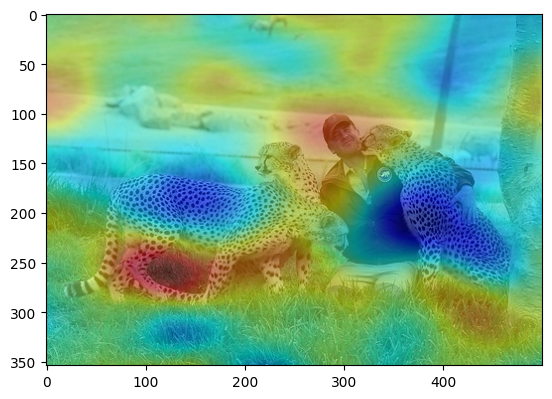

In [17]:
# Save saliency map
output = output_path / "blackbox_explain"
explanation.save(output, image_name)

# See saved saliency maps
image_sal_map = cv2.imread(f"{output}/{image_name}_target_{cheetah_class_index}.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map)
plt.show()

For `BlackBox explainer` the number of masks and cells is crucial for good result. On the example above we see that number of masks wasn't enough for qualitive enough map.

 Varying `num_cells`/`num_masks` parameters can achieve different goals:
- To speed up the explanation, we can reduce the number of `num_mask`. But the result saliency maps will decrease the quality, so this option can be used for big and focused objects.
- The more `num_cells` we have, the more fine-grained result we can expect. But more `num_cells` requires bigger `num_masks` to converge. This would work better work for classes with complex shape.

# <a id='toc6_'></a>[Advanced](#toc0_)
## <a id='toc6_1_'></a>[Import ImageNet label names and add them to saliency maps](#toc0_)

If model doesn't have a label list in meta information, the saved saliency map will have the predicted class index, not name. For example,  `cheetah_person_target_293.jpg` instead of `cheetah_person_target_cheetah.jpg`. 

To see the predicted label name more conveniently, let's add ImageNet label list info into explaination parameters. 

In [18]:
! wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2024-06-17 21:42:12--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving proxy-dmz.intel.com (proxy-dmz.intel.com)... 10.184.220.176
Connecting to proxy-dmz.intel.com (proxy-dmz.intel.com)|10.184.220.176|:912... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.02s   

2024-06-17 21:42:13 (469 KB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



In [19]:
# Get ImageNet labels to add them to explanations
f = open("imagenet_classes.txt", "r")
imagenet_labels = []
for label in f.readlines():
    class_label = label.replace(" ", "_")[:-1]
    imagenet_labels.append(class_label)

print(" ".join(imagenet_labels[:10]))

tench goldfish great_white_shark tiger_shark hammerhead electric_ray stingray cock hen ostrich


In [20]:
# Create ov.Model
model = ov.Core().read_model(model_path)

# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.WHITEBOX,
)

# Adding ImageNet label names.
explanation = explainer(image,
                        target_explain_labels=["cheetah"], # Also [293] is possible
                        label_names=imagenet_labels
                        )

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


In [21]:
# Save saliency map
output = output_path / "label_names"
explanation.save(output, image_name)

Below in `output / "label_names"` you can see saved saliency maps with label name on it:

In [23]:
# See saliency mas saved in `output` with predicted label in image name
! ls -l $output

total 28
-rw-r--r-- 1 gzalessk gzalessk 25220 Jun 17 21:46 cheetah_person_target_cheetah.jpg
